In [3]:
%pylab inline
rc("image", cmap="gray", interpolation="nearest")
figsize(7, 7)

Populating the interactive namespace from numpy and matplotlib


# PyTorch

"Tensors and Dynamic neural networks in Python with strong GPU acceleration"

- like Matlab or Numpy, but with GPU support
- automatic, dynamic differentiation and gradient descent
- some frameworks for neural networks

# SIMPLE COMPUTATIONS

In [4]:
# simple "tensors" (multidimensional numerical arrays) in Torch

import torch
data = torch.rand(256, 256)
print(data)

tensor([[0.8471, 0.9479, 0.4221,  ..., 0.0315, 0.7611, 0.2666],
        [0.4063, 0.0180, 0.1343,  ..., 0.3172, 0.3839, 0.7551],
        [0.3239, 0.2412, 0.4701,  ..., 0.6936, 0.3403, 0.9588],
        ...,
        [0.5719, 0.6161, 0.8237,  ..., 0.6055, 0.6667, 0.7735],
        [0.4981, 0.6356, 0.0173,  ..., 0.2129, 0.9506, 0.9643],
        [0.0525, 0.1073, 0.5528,  ..., 0.4698, 0.8122, 0.3254]])


In [5]:
# a pointless GPU computation

if torch.has_cuda:
    data = torch.rand(256, 256).cuda()
    out = data
    for i in range(100):
        out = torch.mm(data, out)
        out /= out.norm()
    imshow(out.cpu().numpy())
else:
    print("CUDA not available")

CUDA not available


# PyTorch 

- standard set of numerical operations
- similar primitives to Numpy, Matlab
- operations run on CPU and GPU
- GPU operations use CUDA, cuDNN, some third party kernels
- direct binding: you call a numerical function, it calls the kernel

# AUTOMATIC DIFFERENTIATION

In [6]:
def tshow(image, **kw):
    if image.ndimension()==2:
        imshow(image.detach().cpu().numpy(), **kw)
    elif image.ndimension()==3:
        if image.shape[0]==1:
            tshow(image[0])
        else:
            imshow(image.detach().cpu().permute(1, 2, 0).numpy(), **kw)
    elif image.ndimension()==4:
        tshow(image[0])

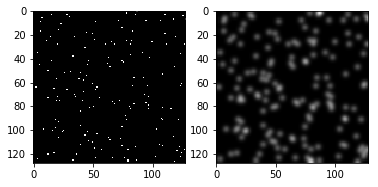

In [7]:
def generate_pair():
    image = (torch.rand((128, 128)) > 0.99).type(torch.float)
    import scipy.ndimage as ndi
    target = torch.tensor(ndi.gaussian_filter(image.numpy(), 2.0))
    return image, target

image, target = generate_pair()
subplot(121); tshow(image); subplot(122); tshow(target)

# 2D Convolutions

In [8]:
import torch.nn.functional as F

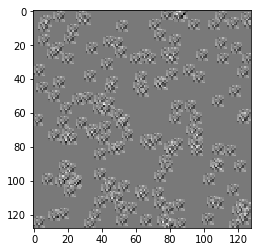

In [17]:
x = image[None, None, :, :]
y = target[None, None, :, :]

w = torch.randn(1, 1, 7, 7)
w.requires_grad = True
x.requires_grad = True

y_predicted = F.conv2d(x, w, padding=3)

tshow(y_predicted)

In [18]:
w

tensor([[[[ 1.4969,  1.0356,  0.4065, -0.9697,  0.6189,  0.4487, -0.1788],
          [ 0.4491,  1.4204,  0.1275, -1.6154,  0.1181,  0.6485, -1.5142],
          [ 0.1943, -1.7296, -1.6345,  1.9833, -1.6112,  0.7646,  1.4480],
          [ 0.0103, -1.9432,  0.2640,  0.3675,  0.3609, -0.0514,  1.2510],
          [-0.9231,  0.5609, -0.5284,  0.6244,  1.4480,  0.3570,  0.8406],
          [ 0.9273,  0.1563,  0.6437,  0.3238, -0.6947,  0.3382,  0.9340],
          [ 0.3922,  0.8580,  2.2139,  0.4930,  1.2609, -0.5197, -0.0028]]]],
       requires_grad=True)

In [19]:
w.grad

# Computing the Error

In [20]:
err = ((y_predicted - y)**2).sum()
print(err)

err.backward(retain_graph=True)
print(w.grad)

tensor(7400.3457, grad_fn=<SumBackward0>)
tensor([[[[ 438.3613,  314.1556,   99.5930, -288.6387,  230.4637,  148.2259,
            -31.7791],
          [ 156.8559,  439.3134,   60.5004, -469.8294,   72.7932,  254.6094,
           -437.6075],
          [  73.8133, -505.6537, -464.5374,  657.4180, -467.0169,  256.4970,
            450.5425],
          [  54.5991, -566.8817,  100.5234,  181.2554,  151.2442,  -19.1624,
            402.8323],
          [-250.6139,  194.0660, -167.7104,  195.8242,  440.2630,   98.5370,
            272.9865],
          [ 251.0197,   49.6346,  214.6713,   96.5031, -207.3371,  125.3598,
            290.4129],
          [ 116.0852,  262.5845,  672.8962,  167.6848,  400.5080, -134.5549,
             29.2905]]]])


In [21]:
from graphviz import Digraph
def make_dot(var, params):
    """ Produces Graphviz representation of PyTorch autograd graph
    
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    param_map = {id(v): k for k, v in params.items()}
    print(param_map)
    
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='9',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12", rankdir="LR"))
    seen = set()
    
    def size_to_str(size):
        return '('+(', ').join(['%d'% v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                node_name = '%s\n %s' % (param_map.get(id(u)), size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

# Computation Graph

{140567595793792: 'w', 140567595798600: 'x'}


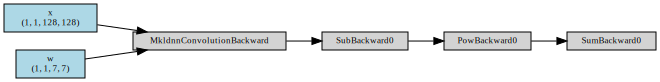

In [22]:
make_dot(err, dict(w=w, x=x))

# PyTorch Autograd Summary

- Tensors $\rightarrow$ Variables
- PyTorch keeps track of derivatives
- computation graphs can be completely dynamic
- propagate derivatives backwards using `x.backward()`
- access gradients using `x.grad`

# SIMPLE LEARNING

In [23]:
from torch import optim
import torch.nn.functional as F

x, y = generate_pair()
w = torch.randn(1, 1, 7, 7)
w.requires_grad = True

for i in range(5000):
    if w.grad is not None: w.grad.fill_(0)
    y_predicted = F.conv2d(x[None, None, :, :], w, padding=3)
    err = ((y_predicted - y[None, None, :, :])**2).sum()
    err.backward()
    w.data -= 1e-5 * w.grad
    if i%1000==0: print(f"{i:6d} {err.item():.3f}")

     0 8478.011
  1000 10.606
  2000 0.165
  3000 0.150
  4000 0.150


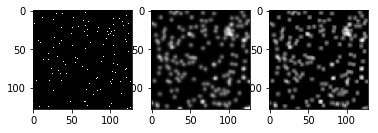

In [24]:
# input, desired output, learned output via gradient descent
subplot(131); tshow(x); subplot(132); tshow(y); subplot(133); tshow(y_predicted)

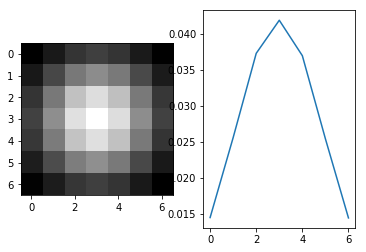

In [25]:
subplot(121); tshow(w); subplot(122); plot(w[0, 0, 3, :].detach().numpy())

# Learning a Linear Filter with Layers

- above example used gradient descent using completely functional computations
- a `Conv2d` layer is the same as a linear filter
- let's see whether we can learn this using PyTorch
- this uses all the components we need to train more complex models in PyTorch

In [29]:
from torch import nn, optim

# the "model" is just a single convolutional layer
model = nn.Conv2d(1, 1, (17, 17), padding=8)

# the loss is MSE loss
criterion = nn.MSELoss()

In [30]:
x, y = generate_pair()

for i in range(5000):
    
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    optimizer.zero_grad()
    
    y_predicted = model(x[None, None, :, :])
    
    loss = criterion(y[None, None, :, :], y_predicted)
    if i%1000==0: print(i, loss.item())
    loss.backward()
    
    optimizer.step()

0 0.006330833770334721
1000 7.773120887577534e-05
2000 6.487645350716775e-06
3000 4.518406058195978e-06
4000 4.45154364570044e-06


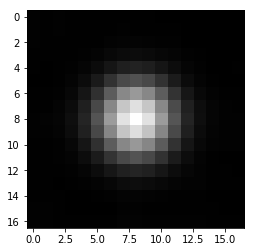

In [31]:
# display the learned kernel
parameters = list(model.parameters())
imshow(parameters[0].data[0,0].cpu().numpy())

# Torch "Modules" / "Layers"

In [32]:
import torch.functional as F

class Linear(nn.Module):
    def __init__(self, ninput, noutput):
        self.weights = Parameter(torch.randn(noutput, ninput))
    def forward(self, x):
        return F.linear(x, self.weights)
    # NB: no "backward" method needed

# Composition of Torch Layers

In [33]:
model = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2)  
)
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

# SHAPE INFERENCE, INPUT, REORDER

# Manual Sizes

Keeping track of depths can be complicated in the presence of padding and reshaping.

In [42]:
model = nn.Sequential(
    nn.Conv2d(1, 8, 3),
    nn.ReLU(),
    nn.Conv2d(8, 16, 3),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(2304, 10)
)
model(torch.randn(1, 1, 16, 16)).shape

torch.Size([1, 10])

# Shape Inference

Shape inference simplifies this.

In [43]:
from torchmore import layers, flex
model = nn.Sequential(
    flex.Conv2d(8, 3),
    nn.ReLU(),
    flex.Conv2d(16, 3),
    nn.ReLU(),
    nn.Flatten(),
    flex.Linear(10)
)
model(torch.randn(1, 1, 16, 16)).shape

torch.Size([1, 10])

# How `flex` works

`flex` simply delays allocation of layers until the first forward pass.

In [44]:
model = nn.Sequential(
    flex.Conv2d(16, 3),
    nn.ReLU(),
    nn.Flatten(),
    flex.Linear(10)
)
model

Sequential(
  (0): Flex:None
  (1): ReLU()
  (2): Flatten()
  (3): Flex:None
)

In [45]:
with torch.no_grad():
    model.forward(torch.randn(1, 1, 64, 64))
model

Sequential(
  (0): Flex:Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Flatten()
  (3): Flex:Linear(in_features=61504, out_features=10, bias=True)
)

# Converting to Standard Models

`flex.freeze` turns a flex model into a standard model.

In [46]:
flex.freeze(model)
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Flatten()
  (3): Linear(in_features=61504, out_features=10, bias=True)
)

# Generic `Flex` Modules

In [50]:
model = nn.Sequential(flex.Flex(lambda x: nn.Conv2d(x.size(1), 10, 3)))
print(model)
model.forward(torch.rand(1, 1, 8, 8))
print(model)
flex.freeze(model)
print(model)

Sequential(
  (0): Flex:None
)
Sequential(
  (0): Flex:Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
)
Sequential(
  (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
)


# Building Abstractions

Clever use of Python syntax makes it easy to build complex models out of building blocks.

In [47]:
def conv2d(d, r=3, mp=None):
    result = [
        flex.Conv2d(16, r, padding=r//2),
        flex.BatchNorm2d(),
        nn.ReLU()
    ]
    if mp is not None: result += [nn.MaxPool2d(mp)]
    return result

model = nn.Sequential(
    *conv2d(16),
    *conv2d(32, mp=2)
)
flex.shape_inference(model, (1, 1, 64, 64))
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [27]:
# Input layers

model = nn.Sequential(
    layers.Input(assume="BDHW", sizes=((1, 256), 3, None, None), dtype=torch.float32),
    *conv2d(16, 7, mp=2),
    *conv2d(32, mp=2)
)

flex.shape_inference(model, (1, 3, 64, 64))
model

Sequential(
  (0): Input(BDHW->BDHW torch.float32 None cpu ((1, 256), 3, None, None))
  (1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [28]:
# Fun, Reorder layers

model = nn.Sequential(
    layers.Input(assume="BDHW", sizes=((1, 256), 3, None, None), dtype=torch.float32),
    *conv2d(16, 7, mp=2),
    *conv2d(32, mp=2),
    layers.Fun("lambda x: x.sum(1)"),
    layers.Reorder("BDL", "LBD")
)

flex.shape_inference(model, (1, 3, 64, 64))
model

Sequential(
  (0): Input(BDHW->BDHW torch.float32 None cpu ((1, 256), 3, None, None))
  (1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Fun None lambda x: x.sum(1)
  (10): Reorder("BDL", "LBD")
)

# Summary of Torch "Modules" and Training

- training uses modules, criteria, and optimizers
- modules (nn.Module) keep track of parameters and compute in the forward method
- criteria compute the differences between two outputs and return a scalar loss
- optimizers initiate gradient computation and then update the model parameters

# PYTORCH VS OTHERS

# Common Deep Learning Frameworks

Primary:

- TensorFlow
- PyTorch (old: Torch)
- Caffe 2 (old: Caffe)
- mxnet
- Chainer

Derived:

- Keras
- Theano

# TensorFlow

- superficially like PyTorch, but internally very different
- core is a dataflow language, completely separate from Python

Issues:
- tons of code between you and the kernels
- many custom written Google kernels
- memory hungry
- RNN support is worse

# PyTorch

Issues:

- Python multithreading is poor, therefore...
- limited ability to write high performance multi-GPU code

Potential Solutions:
- port to IronPython (C#, .NET)
- future, better Python JIT/compilers

# Future?

- both PyTorch and Tensorflow have serious limitations
- either they will substantially, or new frameworks will come around